In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
np.random.seed(2022)

### 데이터 생성하기

In [3]:
# =========================================
# 시계열 데이터 생성
# =========================================
n = 2349
p = 10
b_vec = np.arange(p,0,-1)/10
x_mat = np.random.normal(0,1,[n,p])
y_vec = np.dot(x_mat,b_vec) + np.random.normal(0,1,n)
y_vec = y_vec.cumsum()
y_vec = y_vec + abs(y_vec.min() )+ 100

In [4]:
# =========================================
# X ,Y 데이터 생성
# =========================================
columns = ["xvar_{}".format(x) for x in np.arange(0,10)]
xDF = pd.DataFrame(x_mat, columns = columns)
yDF = pd.DataFrame(y_vec,columns = ['Price'])
xyDF = pd.concat([xDF,yDF], axis = 1)

In [5]:
# =========================================
# Date 데이터 생성
# =========================================
xyDF['Date'] = pd.date_range(start = '2013-01-01', end = '2021-12-31', freq = '1B')

(array([15340., 15706., 16071., 16436., 16801., 17167., 17532., 17897.,
        18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

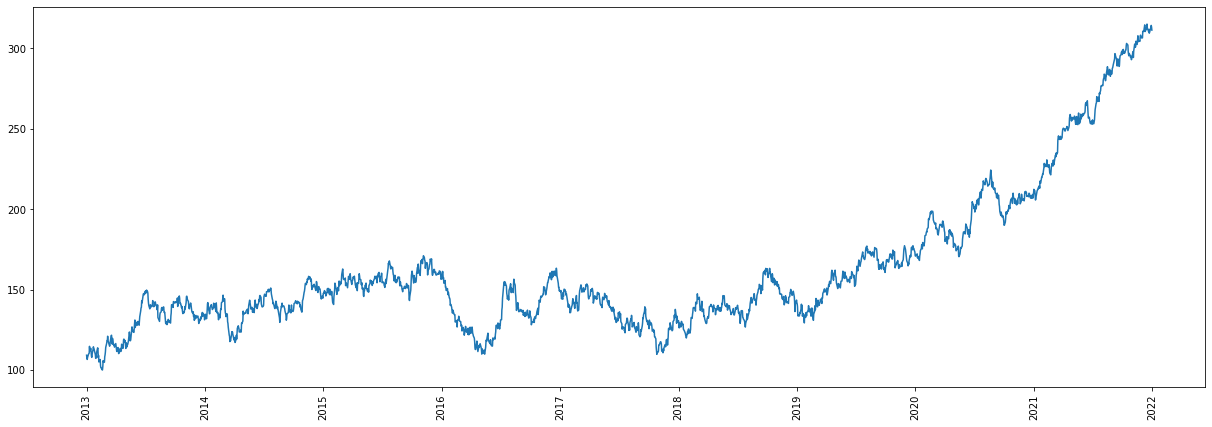

In [6]:
# =========================================
# Price 그래프 그려보기
# =========================================
plt.figure(figsize = [21,7])
plt.plot(xyDF['Date'], xyDF['Price'])
plt.xticks(rotation = 90)

### 데이터 전처리

In [7]:
# =========================================
# 65일 후 주가 예측 모델을 위한 데이터 전처리
# 학습      : 1040일(4년)
# Valdation : 65일(3개월)
# Test      : 65일 (3개월) 
# =========================================

model_code = 65
base_date = '20210101'

test_end_date = pd.date_range(base_date, periods=2, freq = "{}B".format(model_code))[1]
test_start_date = pd.date_range(test_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_end_date = pd.date_range(test_start_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_start_date = pd.date_range(valid_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
train_end_date = pd.date_range(valid_start_date, periods = 2, freq = "-{}B".format(1))[1]
train_start_date = pd.date_range(train_end_date, periods = 2, freq = "-{}B".format(1040))[1]


date_df = pd.DataFrame({"train_start" : train_start_date,
                        "train_end" : train_end_date,
                        "valid_start" : valid_start_date,
                        "valid_end" : valid_end_date,
                        "test_start" : test_start_date,
                        "test_end" : test_end_date}, index = [0])

date_df

,train_start,train_end,valid_start,valid_end,test_start,test_end
0,2016-07-07,2020-07-02,2020-07-03,2020-10-02,2021-01-01,2021-04-02


In [8]:
# =========================================
# Y 및 Y의 일자 생성
# =========================================
xyDF['Y'] = xyDF['Price'].shift(-65)
# xyDF['Y'] = xyDF['Price'].pct_change(65).shift(-65)
xyDF['Y_DATE'] = list(map(lambda xx : pd.date_range(xx, periods = 2, freq = '65B')[1],xyDF.Date))

In [9]:
# =========================================
# GRU X 데이터 생성을 위한 인덱스 Array 만들기
# EX)
#  : np.arange(0, 0 + nSteps * nInterval ,nInterval)
#  : np.arange(1, 1 + nSteps * nInterval ,nInterval)
#  : np.arange(2, 3 + nSteps * nInterval ,nInterval)
#  : np.arange(2209, 2209 + nSteps * nInterval ,nInterval)
#  : np.arange(x, x + nSteps * nInterval, nInterval)
# =========================================

nSteps = 15
nInterval = 10
dimBatch = len(xyDF) - nInterval*(nSteps - 1)
listidx = [np.arange(x, x + nSteps * nInterval, nInterval) for x in range(dimBatch)]

In [10]:
# =========================================
# GRU X, Y 데이터 생성
# =========================================

x_var = [s for s in xyDF.columns if 'xvar' in s]
GRU_x = []
GRU_y = []
GRU_date = []

for i in range(dimBatch):
    
    ind = listidx[i]
    sub_xyDF = xyDF.iloc[ind,:]
    x = np.array(sub_xyDF[x_var])
    y = np.array(sub_xyDF.tail(1)['Y'])        # 해당 X의 가장 마지막 Y
    date = sub_xyDF.tail(1)[["Date","Y_DATE"]] # 해당 Y의 일자 -> Train, Valid, Test 구분을 위해 필요
    
    GRU_x.append(x)
    GRU_y.append(y)
    GRU_date.append(date)
    
    del(x,y,date,ind,sub_xyDF)
    
GRU_x = np.array(GRU_x)
GRU_y = np.array(GRU_y)
GRU_date = pd.concat(GRU_date)

In [11]:
print('X shape : ', GRU_x.shape)
print('y shape : ', GRU_y.shape)
print('date shape : ', GRU_date.shape)

X shape :  (2209, 15, 10)
y shape :  (2209, 1)
date shape :  (2209, 2)


In [12]:
# =========================================
# Train, Valid, Test 데이터로 분할
# =========================================

# 날짜 데이터 프레임으로 Train, Valid, Test Index 생성
Train_Index = (date_df.train_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.train_end[0])
Valid_Index = (date_df.valid_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.valid_end[0])
Test_Index = (date_df.test_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.test_end[0])

# Train, Valid, Test 데이터 생성
Train_GRU_x = GRU_x[Train_Index,:,:]
Train_GRU_y = GRU_y[Train_Index,:]

Valid_GRU_x = GRU_x[Valid_Index,:,:]
Valid_GRU_y = GRU_y[Valid_Index,:]

Test_GRU_x = GRU_x[Test_Index,:,:]
Test_GRU_y = GRU_y[Test_Index,:]

In [13]:
# =========================================
# Min, Max Scale
# =========================================
# 각 Feature 별 Min Max 값 생성
Min_Max_DF = pd.DataFrame({})
for ind in range(Train_GRU_x.shape[2]):
    Max = Train_GRU_x[:,:,ind].max()
    Min = Train_GRU_x[:,:,ind].min()
    Min_Max_DF = pd.concat([Min_Max_DF, pd.DataFrame({"Feature_No": ind , "Max" : Max, "Min" : Min}, index = [0])])
    
Min_Max_DF.reset_index(drop = True, inplace = True)


# 각 Feature 별 Min Max Scale 진행
for ind in range(Train_GRU_x.shape[2]):
    # Train Min Max Scale
    Train_GRU_x[:,:,ind] = (Train_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])

    # Valid Min Max Scale
    Valid_GRU_x[:,:,ind] = (Valid_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] >= 1 , 1, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] <= 0 , 0, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

    # Test Min Max Scale
    Test_GRU_x[:,:,ind] = (Test_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] >= 1 , 1, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] <= 0 , 0, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

In [14]:
# ===========================================================
# GRU
# ===========================================================

# nSteps = 15
nFeatures = p
Hidden_unit1 = 10
Hidden_unit2 = 10
BatchSize = 16
nStacks = 5
Learning_rate = 0.0001
Patience = 20
seed = 2022

layer_input = tf.keras.Input(shape = (nSteps, nFeatures), name = 'input')
layer_state = tf.keras.layers.GRU(Hidden_unit1, return_state = True, name = 'gru_initial_state')(layer_input)[1]
layer_gru = tf.keras.layers.GRU(Hidden_unit1, return_sequences = True, name = 'gru_cell_0')(layer_input, initial_state = layer_state)

if nStacks >1 :
    for x in range(nStacks-1):
        layer_gru = tf.keras.layers.GRU(Hidden_unit2, return_sequences = True, name = 'gru_cell_{}'.format(x+1))(layer_gru)

layer_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 1, activation = 'linear',
                                                                    kernel_regularizer = tf.keras.regularizers.l2(l=0.2),
                                                                    kernel_initializer = tf.keras.initializers.orthogonal(seed = seed))
                                              , name = 'output')(layer_gru)     
gru_model = tf.keras.Model(layer_input, layer_output)

# GRU Model Summary
gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 15, 10)]     0           []                               
                                                                                                  
 gru_initial_state (GRU)        [(None, 10),         660         ['input[0][0]']                  
                                 (None, 10)]                                                      
                                                                                                  
 gru_cell_0 (GRU)               (None, 15, 10)       660         ['input[0][0]',                  
                                                                  'gru_initial_state[0][1]']      
                                                                                              

In [15]:
# Compile
opim = tf.keras.optimizers.Adam(learning_rate = Learning_rate, beta_1=0.9, beta_2=0.999, decay=0.01)
gru_model.compile(optimizer = opim, loss = "mean_squared_error")

C:\Users\jblee\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Early Stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = Patience, verbose = 1)

In [17]:
# Best Model Check Point
#'D:/workspace/PSC/MODEL/GRU_{epoch:02d}-{val_loss:.5f}.h5' -> epoch, val_loss 명으로 모델 저장
#
ModelCheck = tf.keras.callbacks.ModelCheckpoint(filepath = 'D:/workspace/PSC/MODEL/GRU_Model_01.h5'
                                                , monitor = 'val_loss'
                                                , mode = 'min'
                                                , save_best_only = True)

In [18]:
# GRU MODEL FIT
gru_model.fit(Train_GRU_x, Train_GRU_y
              , epochs = 200
              , batch_size = BatchSize
              , validation_data=(Valid_GRU_x, Valid_GRU_y)
              , callbacks = [EarlyStopping, ModelCheck])

Epoch 1/200
66/66 [==============================] - 8s 33ms/step - loss: 22744.7383 - val_loss: 43498.1523
Epoch 2/200
66/66 [==============================] - 1s 12ms/step - loss: 22710.7617 - val_loss: 43454.9922
Epoch 3/200
66/66 [==============================] - 1s 12ms/step - loss: 22681.2031 - val_loss: 43415.7148
Epoch 4/200
66/66 [==============================] - 1s 12ms/step - loss: 22654.1758 - val_loss: 43379.6289
Epoch 5/200
66/66 [==============================] - 1s 12ms/step - loss: 22629.2461 - val_loss: 43346.3125
Epoch 6/200
66/66 [==============================] - 1s 12ms/step - loss: 22606.4395 - val_loss: 43315.9375
Epoch 7/200
66/66 [==============================] - 1s 12ms/step - loss: 22585.5312 - val_loss: 43287.9883
Epoch 8/200
66/66 [==============================] - 1s 12ms/step - loss: 22566.3223 - val_loss: 43262.3008
Epoch 9/200
66/66 [==============================] - 1s 12ms/step - loss: 22548.6543 - val_loss: 43238.6562
Epoch 10/200
66/66 [========

66/66 [==============================] - 1s 12ms/step - loss: 22224.6680 - val_loss: 42796.4766
Epoch 77/200
66/66 [==============================] - 1s 12ms/step - loss: 22222.9922 - val_loss: 42794.1406
Epoch 78/200
66/66 [==============================] - 1s 12ms/step - loss: 22221.3320 - val_loss: 42791.8438
Epoch 79/200
66/66 [==============================] - 1s 12ms/step - loss: 22219.7012 - val_loss: 42789.5820
Epoch 80/200
66/66 [==============================] - 1s 12ms/step - loss: 22218.0977 - val_loss: 42787.3633
Epoch 81/200
66/66 [==============================] - 1s 12ms/step - loss: 22216.5137 - val_loss: 42785.1680
Epoch 82/200
66/66 [==============================] - 1s 12ms/step - loss: 22214.9648 - val_loss: 42783.0078
Epoch 83/200
66/66 [==============================] - 1s 12ms/step - loss: 22213.4277 - val_loss: 42780.8750
Epoch 84/200
66/66 [==============================] - 1s 12ms/step - loss: 22211.9141 - val_loss: 42778.7695
Epoch 85/200
66/66 [============

66/66 [==============================] - 1s 12ms/step - loss: 22142.2168 - val_loss: 42681.7891
Epoch 151/200
66/66 [==============================] - 1s 12ms/step - loss: 22141.4590 - val_loss: 42680.7383
Epoch 152/200
66/66 [==============================] - 1s 12ms/step - loss: 22140.7109 - val_loss: 42679.6875
Epoch 153/200
66/66 [==============================] - 1s 12ms/step - loss: 22139.9648 - val_loss: 42678.6523
Epoch 154/200
66/66 [==============================] - 1s 12ms/step - loss: 22139.2266 - val_loss: 42677.6172
Epoch 155/200
66/66 [==============================] - 1s 12ms/step - loss: 22138.4902 - val_loss: 42676.6016
Epoch 156/200
66/66 [==============================] - 1s 12ms/step - loss: 22137.7598 - val_loss: 42675.5898
Epoch 157/200
66/66 [==============================] - 1s 12ms/step - loss: 22137.0488 - val_loss: 42674.5859
Epoch 158/200
66/66 [==============================] - 1s 12ms/step - loss: 22136.3262 - val_loss: 42673.5898
Epoch 159/200
66/66 [===

In [19]:
# GRU MODEL 불러오기
model_01 = tf.keras.models.load_model('D:/workspace/PSC/MODEL/GRU_Model_01.h5')

In [26]:
# Prediction Value
Prediction = model_01.predict(Test_GRU_x)
True_y = xyDF.loc[(date_df.test_start[0] <= xyDF.Y_DATE)& (xyDF.Y_DATE <= date_df.test_end[0]),"Y"]

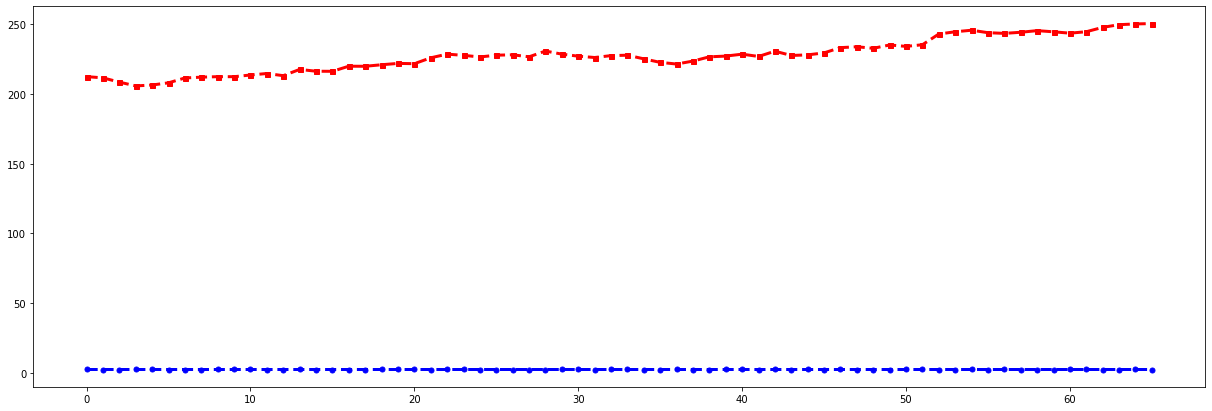

In [54]:
# Plot
plt.figure(figsize = (21,7))
plt.plot(True_y.values, 'rs--', lw = 3, ms = 5)
plt.plot(Prediction[:,14,:], 'bo--', lw = 3, ms = 5)